# Store greenspace metrics at multiple spatial scales

In [9]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
from geopandas import GeoSeries
from numpy.random import RandomState
from skimage.filters.rank import modal
from skimage.util import img_as_ubyte

%matplotlib inline

In [53]:
#!pip install scikit-learn
#!pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 16.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 16.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.9 MB/s eta 0:00:0000:0100:01


# 1. NDVI

## 1.1. NDVI input map

In [2]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [3]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [4]:
ndvi_input_raster.bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

In [4]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

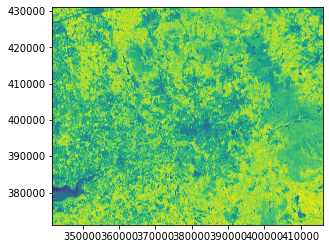

<AxesSubplot:>

In [6]:
# plot input NDVI
show(ndvi_input_raster, 1)

## 1.2. Focal statistics

### 1.2.1. Focal statistics at 100m

In [5]:
# design kernel at a 100m scale
ndvi_filter_100 = np.ones((21, 21))
ndvi_filter_100.shape

(21, 21)

In [10]:
# FFT convolve NDVI input with kernel at 100m (equivalent to average operation)
start_time = time.time()
ndvi_output_100_fft = fftconvolve(ndvi_input, scale_100, mode = "same") / np.sum(scale_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_100_fft.shape

--- 2.755885124206543 seconds ---


(5987, 7443)

### 1.2.2. Focal statistics at 300m

In [16]:
# design kernel at a 300m scale
ndvi_filter_300 = np.ones((61, 61))
ndvi_filter_300.shape

(61, 61)

In [18]:
# FFT convolve NDVI input with kernel at 300m (equivalent to average operation)
start_time = time.time()
ndvi_output_300_fft = fftconvolve(ndvi_input, ndvi_filter_300, mode = "same") / np.sum(ndvi_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_300_fft.shape

--- 2.8771889209747314 seconds ---


(5987, 7443)

### 1.2.3. Focal statistics at 500m

In [25]:
# design kernel at a 500m scale
ndvi_filter_500 = np.ones((101, 101))
ndvi_filter_500.shape

(101, 101)

In [27]:
# FFT convolve NDVI input with kernel at 500m (equivalent to average operation)
start_time = time.time()
ndvi_output_500_fft = fftconvolve(ndvi_input, ndvi_filter_500, mode = "same") / np.sum(ndvi_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_500_fft.shape

--- 3.1675503253936768 seconds ---


(5987, 7443)

## 1.3. NDVI output layer

### 1.3.1. NDVI output layer at 100m

In [14]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_100_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_100_fft.shape[0], width = ndvi_output_100_fft.shape[1],
                            count=1, dtype=str(ndvi_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100_fft, 1)
new_dataset.close()

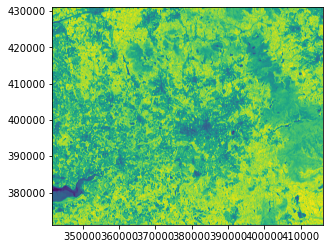

<AxesSubplot:>

In [30]:
# NDVI layer output at 100m
src_100_fft = rasterio.open("thesis_project/output/ndvi_output_100_fft.tif")
show(src_100_fft, 1)

In [19]:
# output layer metadata
src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.2. NDVI output layer at 300m

In [21]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_300_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_300_fft.shape[0], width = ndvi_output_300_fft.shape[1],
                            count=1, dtype=str(ndvi_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_300_fft, 1)
new_dataset.close()

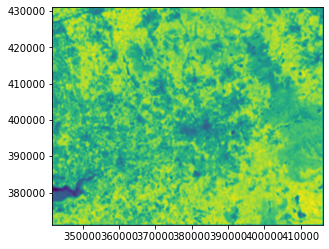

<AxesSubplot:>

In [22]:
# NDVI layer output at 300m
src_300_fft = rasterio.open("thesis_project/output/ndvi_output_300_fft.tif")
show(src_300_fft, 1)

In [24]:
# check meta
src_300_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.3. NDVI output layer at 500m

In [28]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/ndvi_output_500_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_500_fft.shape[0], width = ndvi_output_500_fft.shape[1],
                            count=1, dtype=str(ndvi_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_500_fft, 1)
new_dataset.close()

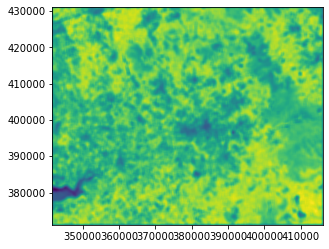

<AxesSubplot:>

In [29]:
# NDVI layer output at 500m
src_500_fft = rasterio.open("thesis_project/output/ndvi_output_500_fft.tif")
show(src_500_fft, 1)

In [22]:
# check crs
src_500_fft.meta

CRS.from_epsg(27700)

## 1.4. Generate random points within extent of raster

### 1.4.1. Generate random points at 100m from each other

In [7]:
# extract raster bounds (later input to create the polygon)
bounds = src_100.bounds
bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

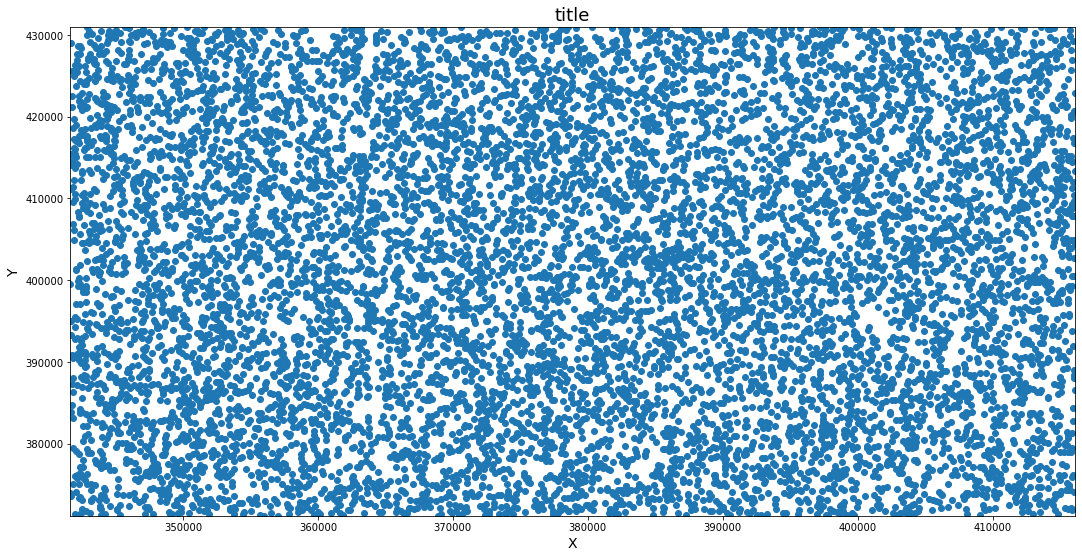

In [52]:
# generate random points at 100m from each other
plt.close("all")

a = 416090.6724         # x bound
b = 431034.6389        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

#prng = RandomState(1234567890)

points_100 = np.array([])       # x, y columnwise
while points_100.shape[0] < 10000:
    np.random.seed(42)
    x = random.choice(np.linspace(341660.6724, a, 100000))
    y = random.choice(np.linspace(371164.6389, b, 100000))
    p = (x,y)
    if len(points_100) == 0:                # add first point blindly
        points_100 = np.array([p])
    elif distance(p, points_100, 100):     # ensure the minimum distance is met
        points_100 = np.vstack((points_100, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([341660.6724, a])
ax.set_ylim([371164.6389, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_100[:,0], points_100[:,1])

In [53]:
# convert np array to point geometry
x, y = np.split(points_100,[-1],axis=1) # split array into x and y
sample_100 = GeoSeries(map(Point, zip(x, y)))
sample_100

0       POINT (363393.705 372747.019)
1       POINT (401914.593 424290.216)
2       POINT (355111.797 390514.816)
3       POINT (386970.388 414807.312)
4       POINT (369133.060 373174.495)
                    ...              
9995    POINT (382445.743 425700.767)
9996    POINT (376142.948 414539.092)
9997    POINT (365276.803 381051.071)
9998    POINT (342291.845 391840.950)
9999    POINT (351294.988 430289.849)
Length: 10000, dtype: geometry

In [54]:
# convert list of point geometries to geodataframe
df_100 = pd.DataFrame(sample_100, columns=['geometry'])
gdf_100 = gpd.GeoDataFrame(df_100, geometry='geometry', crs = 'epsg:27700')
gdf_100.head()                      


,geometry
0,POINT (363393.705 372747.019)
1,POINT (401914.593 424290.216)
2,POINT (355111.797 390514.816)
3,POINT (386970.388 414807.312)
4,POINT (369133.060 373174.495)


In [55]:
# save gpd to GeoJSON
gdf_100.to_file("thesis_project/output/sample_points_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.2. Generate random points at 300m from each other

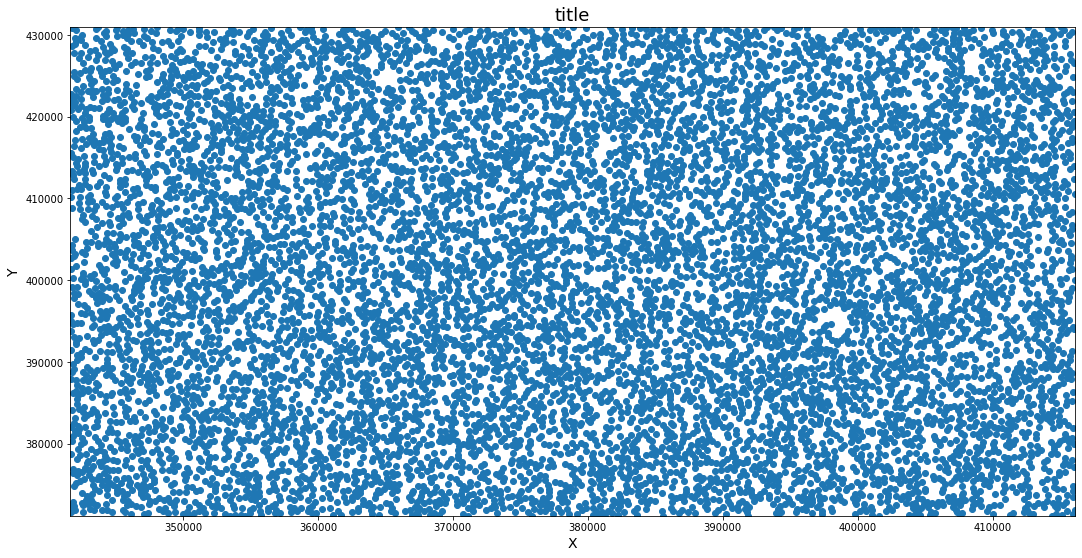

In [14]:
# generate random points at 300m from each other
plt.close("all")

a = 416090.6724         # x bound
b = 431034.6389        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_300 = np.array([])       # x, y columnwise
while points_300.shape[0] < 10000:
    x = random.choice(np.linspace(341660.6724, a, 100000))
    y = random.choice(np.linspace(371164.6389, b, 100000))
    p = (x,y)
    if len(points_300) == 0:                # add first point blindly
        points_300 = np.array([p])
    elif distance(p, points_300, 300):     # ensure the minimum distance is met
        points_300 = np.vstack((points_300, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([341660.6724, a])
ax.set_ylim([371164.6389, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_300[:,0], points_300[:,1])

In [15]:
# convert np array to point geometry
x, y = np.split(points_300,[-1],axis=1) # split array into x and y
sample_300 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_300 = pd.DataFrame(sample_300, columns=['geometry'])
gdf_300 = gpd.GeoDataFrame(df_300, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_300.to_file("thesis_project/output/sample_points_300.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [16]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (345883.129 379224.419),"(345883.12852456124, 379224.4188978)"
1,POINT (349778.834 405585.444),"(349778.8336816128, 405585.4435080461)"
2,POINT (365774.001 395291.891),"(365774.0006332823, 395291.8914725257)"
3,POINT (369488.095 424932.627),"(369488.09477422375, 424932.6274798858)"
4,POINT (385004.672 406986.416),"(385004.67203999637, 406986.4155177662)"


### 1.4.3. Generate random points at 500m from each other

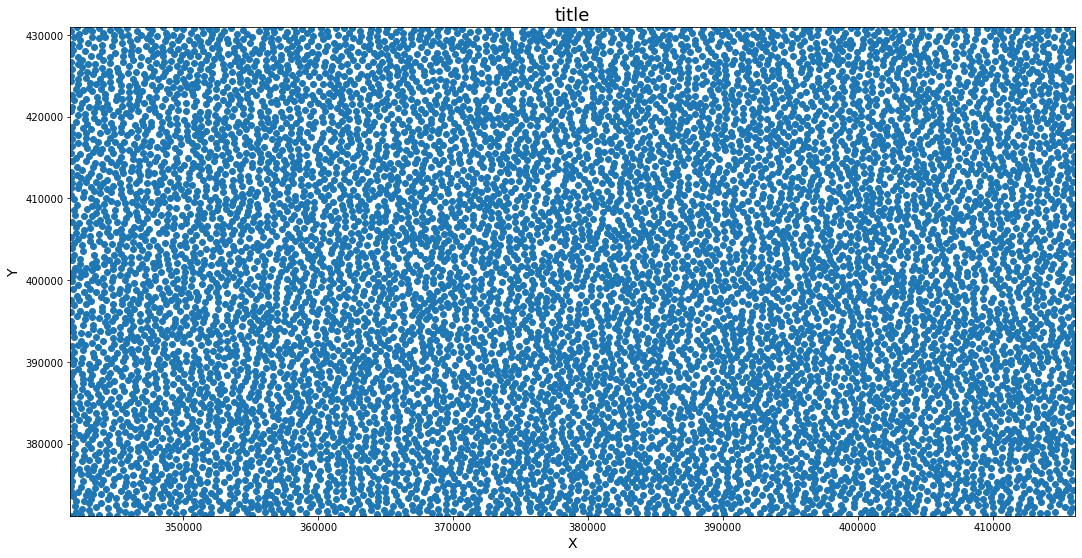

In [17]:
# generate random points at 500m from each other
plt.close("all")

a = 416090.6724         # x bound
b = 431034.6389        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_500 = np.array([])       # x, y columnwise
while points_500.shape[0] < 10000:
    x = random.choice(np.linspace(341660.6724, a, 100000))
    y = random.choice(np.linspace(371164.6389, b, 100000))
    p = (x,y)
    if len(points_500) == 0:                # add first point blindly
        points_500 = np.array([p])
    elif distance(p, points_500, 500):     # ensure the minimum distance is met
        points_500 = np.vstack((points_500, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([341660.6724, a])
ax.set_ylim([371164.6389, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_500[:,0], points_500[:,1])

In [18]:
# convert np array to point geometry
x, y = np.split(points_500,[-1],axis=1) # split array into x and y
points_500 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_500 = pd.DataFrame(points_500, columns=['geometry'])
gdf_500 = gpd.GeoDataFrame(df_500, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_500.to_file("thesis_project/output/sample_points_500.json", driver="GeoJSON")



/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [19]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (354147.918 381837.172),"(354147.9183724597, 381837.17182532925)"
1,POINT (375042.861 410303.845),"(375042.8612218882, 410303.84539206495)"
2,POINT (388441.884 404286.850),"(388441.88381211413, 404286.85022211325)"
3,POINT (381576.392 391094.364),"(381576.39195719553, 391094.363797249)"
4,POINT (373108.406 377313.948),"(373108.40617733775, 377313.94809309195)"


# 1.5. Extract raster values at point locations and store them into a Geodataframe

### 1.5.1. NDVI values at 100m

In [61]:
# read GeoJSON containing random points
gdf_100 = gpd.read_file("thesis_project/output/sample_points_100.json")
gdf_100.head()
#type(gdf_100)

,geometry
0,POINT (363393.705 372747.019)
1,POINT (401914.593 424290.216)
2,POINT (355111.797 390514.816)
3,POINT (386970.388 414807.312)
4,POINT (369133.060 373174.495)


In [62]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_100['point_coordinates'] = point_coords
gdf_100.head()

,geometry,point_coordinates
0,POINT (363393.705 372747.019),"(363393.7054303303, 372747.01882379927)"
1,POINT (401914.593 424290.216),"(401914.59283920436, 424290.2159557706)"
2,POINT (355111.797 390514.816),"(355111.7965112411, 390514.81640177505)"
3,POINT (386970.388 414807.312),"(386970.38799715595, 414807.3118267293)"
4,POINT (369133.060 373174.495),"(369133.06012387725, 373174.49489856)"


In [63]:
# open the raster and store metadata
src_100_fft = rasterio.open("thesis_project/output/ndvi_output_100_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_100['NDVI_100'] = [x[0] for x in src_100_fft.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100
0,POINT (363393.705 372747.019),"(363393.7054303303, 372747.01882379927)",0.582414
1,POINT (401914.593 424290.216),"(401914.59283920436, 424290.2159557706)",0.512916
2,POINT (355111.797 390514.816),"(355111.7965112411, 390514.81640177505)",0.494056
3,POINT (386970.388 414807.312),"(386970.38799715595, 414807.3118267293)",0.610928
4,POINT (369133.060 373174.495),"(369133.06012387725, 373174.49489856)",0.424878


In [65]:
# type of dataframe
type(gdf_100)

geopandas.geodataframe.GeoDataFrame

### 1.5.2. NDVI values at 300m

In [44]:
# read GeoJSON containing random points
gdf_300 = gpd.read_file("thesis_project/output/sample_points_300.json")
gdf_300.head()
#type(gdf_100)

,geometry
0,POINT (345883.129 379224.419)
1,POINT (349778.834 405585.444)
2,POINT (365774.001 395291.891)
3,POINT (369488.095 424932.627)
4,POINT (385004.672 406986.416)


In [45]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (345883.129 379224.419),"(345883.12852456124, 379224.4188978)"
1,POINT (349778.834 405585.444),"(349778.8336816128, 405585.4435080461)"
2,POINT (365774.001 395291.891),"(365774.0006332823, 395291.8914725257)"
3,POINT (369488.095 424932.627),"(369488.09477422375, 424932.6274798858)"
4,POINT (385004.672 406986.416),"(385004.67203999637, 406986.4155177662)"


In [46]:
# open the raster and store metadata
src_300_fft = rasterio.open("thesis_project/output/ndvi_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_300['NDVI_300'] = [x[0] for x in src_300_fft.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300
0,POINT (345883.129 379224.419),"(345883.12852456124, 379224.4188978)",-0.003317
1,POINT (349778.834 405585.444),"(349778.8336816128, 405585.4435080461)",0.440471
2,POINT (365774.001 395291.891),"(365774.0006332823, 395291.8914725257)",0.422367
3,POINT (369488.095 424932.627),"(369488.09477422375, 424932.6274798858)",0.323049
4,POINT (385004.672 406986.416),"(385004.67203999637, 406986.4155177662)",0.578773


### 1.5.3. NDVI values at 500m

In [42]:
# open the raster and store metadata
src_500 = rasterio.open("thesis_project/output/ndvi_output_500.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_500['NDVI_500'] = [x[0] for x in src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500
0,POINT (354147.918 381837.172),"(354147.9183724597, 381837.17182532925)",0.532739
1,POINT (375042.861 410303.845),"(375042.8612218882, 410303.84539206495)",0.545706
2,POINT (388441.884 404286.850),"(388441.88381211413, 404286.85022211325)",0.320074
3,POINT (381576.392 391094.364),"(381576.39195719553, 391094.363797249)",0.523785
4,POINT (373108.406 377313.948),"(373108.40617733775, 377313.94809309195)",0.715961


# 2. Green No Green

## 2.1. Green No Green input map

In [31]:
# data dir
data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

rasterio.io.DatasetReader

In [69]:
# check metadata for the whole raster dataset
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

In [32]:
# read the raster band as separate variable
green_input = green_input_raster.read(1)
#type(green_input)
green_input

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

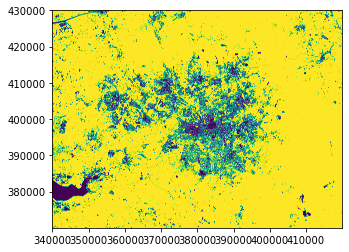

<AxesSubplot:>

In [25]:
# plot input % Greenness
show(green_input_raster, 1)

## 2.2. Focal statistics

### 2.2.1. Focal statistics at 100m

In [33]:
# design kernel at a 100m scale
green_filter_100 = np.ones((41, 41))
green_filter_100.shape

(41, 41)

In [34]:
# FFT convolve Green No Green input with kernel at 100m (r = 41)
start_time = time.time()
green_output_100_fft = fftconvolve(green_input, green_filter_100, mode = "same") / np.sum(green_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_100_fft.shape

--- 27.94204807281494 seconds ---


(12000, 16000)

### 2.2.2. Focal statistics at 300m

In [37]:
# design kernel at a 300m scale
green_filter_300 = np.ones((121, 121))
green_filter_300.shape

(121, 121)

In [38]:
# FFT convolve Green No Green input with kernel at 300m (r = 121)
start_time = time.time()
green_output_300_fft = fftconvolve(green_input, green_filter_300, mode = "same") / np.sum(green_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_300_fft.shape

--- 19.714387893676758 seconds ---


(12000, 16000)

### 2.2.3. Focal statistics at 500m

In [41]:
# design kernel at a 500m scale
green_filter_500 = np.ones((201, 201))
green_filter_500.shape

(201, 201)

In [42]:
# FFT convolve Green No Green input with kernel at 500m (r = 201)
start_time = time.time()
green_output_500_fft = fftconvolve(green_input, green_filter_500, mode = "same") / np.sum(green_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_500_fft.shape

--- 27.058250904083252 seconds ---


(12000, 16000)

## 2.3. Green No Green output layer

In [57]:
# % greenness input map bounds
green_input_raster.bounds

BoundingBox(left=339999.2458, bottom=370003.9122, right=419999.2458, top=430003.9122)

In [58]:
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.1. Green No Green output layer at 100m

In [35]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/green_output_100_fft.tif', 'w', driver='GTiff',
                            height = green_output_100_fft.shape[0], width = green_output_100_fft.shape[1],
                            count=1, dtype=str(green_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_100_fft, 1)
new_dataset.close()

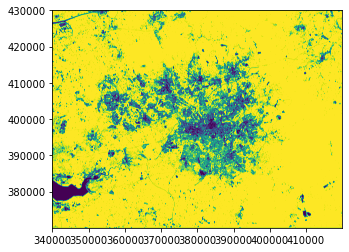

<AxesSubplot:>

In [36]:
# % greenness layer output at 100m
src_100_fft = rasterio.open("thesis_project/output/green_output_100_fft.tif")
show(src_100_fft, 1)

In [29]:
# output layer metadata
src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.2. Green No Green output layer at 300m

In [39]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/green_output_300_fft.tif', 'w', driver='GTiff',
                            height = green_output_300_fft.shape[0], width = green_output_300_fft.shape[1],
                            count=1, dtype=str(green_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_300_fft, 1)
new_dataset.close()

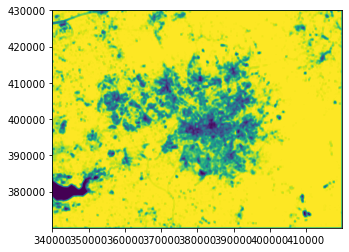

<AxesSubplot:>

In [40]:
# % greenness layer output at 300m
src_300_fft = rasterio.open("thesis_project/output/green_output_300_fft.tif")
show(src_300_fft, 1)

In [ ]:
# output layer metadata
src_300_fft.meta

### 2.3.3. Green No Green output layer at 500m

In [43]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/green_output_500_fft.tif', 'w', driver='GTiff',
                            height = green_output_500_fft.shape[0], width = green_output_500_fft.shape[1],
                            count=1, dtype=str(green_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_500_fft, 1)
new_dataset.close()

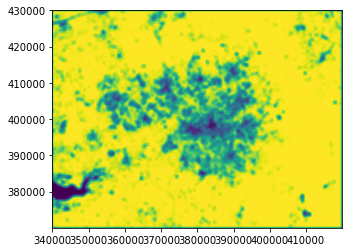

<AxesSubplot:>

In [44]:
# % greenness layer output at 500m
src_500_fft = rasterio.open("thesis_project/output/green_output_500_fft.tif")
show(src_500_fft, 1)

In [ ]:
# output layer metadata
src_500_fft.meta

## 2.4. Extract raster values at point locations and store them into a Geodataframe

### 2.4.1. Green No Green values at 100m

In [64]:
# open the raster and store metadata
green_src_100 = rasterio.open("thesis_project/output/green_output_100_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_100['Green_100'] = [x[0] for x in green_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Green_100
0,POINT (363393.705 372747.019),"(363393.7054303303, 372747.01882379927)",0.582414,1.000000
1,POINT (401914.593 424290.216),"(401914.59283920436, 424290.2159557706)",0.512916,1.000000
2,POINT (355111.797 390514.816),"(355111.7965112411, 390514.81640177505)",0.494056,1.000000
3,POINT (386970.388 414807.312),"(386970.38799715595, 414807.3118267293)",0.610928,0.929804
4,POINT (369133.060 373174.495),"(369133.06012387725, 373174.49489856)",0.424878,1.000000


In [77]:
# check if null values in gdf
gdf_100.isnull().values.any()

False

In [65]:
# drop tuple point_coordinates
gdf_100 = gdf_100[['geometry', 'NDVI_100', 'Green_100']]
gdf_100.head()

,geometry,NDVI_100,Green_100
0,POINT (363393.705 372747.019),0.582414,1.000000
1,POINT (401914.593 424290.216),0.512916,1.000000
2,POINT (355111.797 390514.816),0.494056,1.000000
3,POINT (386970.388 414807.312),0.610928,0.929804
4,POINT (369133.060 373174.495),0.424878,1.000000


In [66]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/greenspace_metrics_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 2.4.2. Green No Green values at 300m

In [47]:
# open the raster and store metadata
green_src_300 = rasterio.open("thesis_project/output/green_output_300.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_300['Green_300'] = [x[0] for x in green_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Green_300
0,POINT (345883.129 379224.419),"(345883.12852456124, 379224.4188978)",-0.003317,0.000000
1,POINT (349778.834 405585.444),"(349778.8336816128, 405585.4435080461)",0.440471,0.012636
2,POINT (365774.001 395291.891),"(365774.0006332823, 395291.8914725257)",0.422367,0.006762
3,POINT (369488.095 424932.627),"(369488.09477422375, 424932.6274798858)",0.323049,0.009084
4,POINT (385004.672 406986.416),"(385004.67203999637, 406986.4155177662)",0.578773,0.012841


In [78]:
# check if null values in gdf
gdf_300.isnull().values.any()

False

In [48]:
# drop tuple point_coordinates
gdf_300 = gdf_300[['geometry', 'NDVI_300', 'Green_300']]
gdf_300.head()

,geometry,NDVI_300,Green_300
0,POINT (345883.129 379224.419),-0.003317,0.000000
1,POINT (349778.834 405585.444),0.440471,0.012636
2,POINT (365774.001 395291.891),0.422367,0.006762
3,POINT (369488.095 424932.627),0.323049,0.009084
4,POINT (385004.672 406986.416),0.578773,0.012841


In [49]:
# save geodataframe to geojson
gdf_300.to_file("thesis_project/output/greenspace_metrics_300.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 2.4.3. Green No Green values at 500m

In [75]:
# open the raster and store metadata
green_src_500 = rasterio.open("thesis_project/output/green_output_500.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_500['Green_500'] = [x[0] for x in green_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Green_500
0,POINT (354147.918 381837.172),"(354147.9183724597, 381837.17182532925)",0.532739,1
1,POINT (375042.861 410303.845),"(375042.8612218882, 410303.84539206495)",0.545706,1
2,POINT (388441.884 404286.850),"(388441.88381211413, 404286.85022211325)",0.320074,0
3,POINT (381576.392 391094.364),"(381576.39195719553, 391094.363797249)",0.523785,1
4,POINT (373108.406 377313.948),"(373108.40617733775, 377313.94809309195)",0.715961,1


In [79]:
# check if null values in gdf
gdf_500.isnull().values.any()

False

In [ ]:
# drop tuple point_coordinates
gdf_500 = gdf_500[['geometry', 'NDVI_300', 'Green_300']]
gdf_500.head()

In [ ]:
# save geodataframe to geojson
gdf_500.to_file("thesis_project/output/greenspace_metrics_500.json", driver="GeoJSON")

# 3. Tree No Trees

## 3.1. Tree No Trees input map

In [45]:
# data dir
data_dir = r"thesis_project/data"
fp_tree = os.path.join(data_dir, "Tree_no_trees_2m.TIF")

# open the file
tree_input_raster = rasterio.open(fp_tree)

# check type of the variable 'raster'
type(tree_input_raster)

rasterio.io.DatasetReader

In [51]:
# check metadata for the whole raster dataset
tree_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

In [46]:
# read the raster band as separate variable
tree_input = tree_input_raster.read(1)
#tree_input
type(tree_input)


numpy.ndarray

In [53]:
# convert array to uint8
tree_input = tree_input.astype(np.uint8)
tree_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

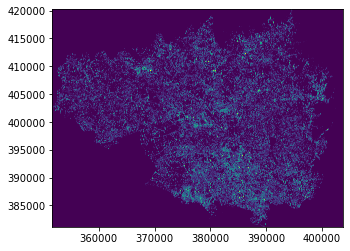

<AxesSubplot:>

In [54]:
# plot Tree No Trees input map
show(tree_input_raster, 1)

## 3.2. Focal statistics

### 3.2.1. Focal statistics at 100m

In [47]:
# design kernel at a 100m scale
tree_filter_100 = np.ones((101, 101))
tree_filter_100.shape

(101, 101)

In [ ]:
# convolve Tree No Trees input with kernel 100m (r = 101)
tree_output_100 = convolve(tree_input, tree_filter_100) / np.sum(tree_filter_100)
tree_output_100.shape


In [48]:
# FFT convolve Tree No Trees input with kernel at 100m (r = 101)
start_time = time.time()
tree_output_100_fft = fftconvolve(tree_input, tree_filter_100, mode = "same") / np.sum(tree_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_100_fft.shape

--- 103.93113994598389 seconds ---


(19520, 26119)

### 3.2.2. Focal statistics at 300m

In [51]:
# design kernel at a 300m scale
tree_filter_300 = np.ones((301, 301))
tree_filter_300.shape

(301, 301)

In [ ]:
# convolve Tree No Trees input with kernel 300m (r = 301)
tree_output_300 = convolve(tree_input, tree_filter_300) / np.sum(tree_filter_300)
tree_output_300.shape

In [52]:
# FFT convolve Tree No Trees input with kernel at 300m (r = 301)
start_time = time.time()
tree_output_300_fft = fftconvolve(tree_input, tree_filter_300, mode = "same") / np.sum(tree_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_300_fft.shape

--- 103.36607098579407 seconds ---


(19520, 26119)

### 3.2.3. Focal statistics at 500m

In [53]:
# design kernel at a 500m scale
tree_filter_500 = np.ones((501, 501))
tree_filter_500.shape

(501, 501)

In [ ]:
# convolve Tree No Trees input with kernel 500m (r = 501)
tree_output_500 = convolve(tree_input, tree_filter_500) / np.sum(tree_filter_500)
tree_output_500.shape

In [54]:
# FFT convolve Tree No Trees input with kernel at 500m (r = 501)
start_time = time.time()
tree_output_500_fft = fftconvolve(tree_input, tree_filter_500, mode = "same") / np.sum(tree_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_500_fft.shape

--- 130.13425302505493 seconds ---


(19520, 26119)

## 3.3. Tree no Trees output layer

In [15]:
# checking bounds
tree_input_raster.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

### 3.3.1. Tree no Trees output layer at 100m

In [49]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/tree_output_100_fft.tif', 'w', driver='GTiff',
                            height = tree_output_100_fft.shape[0], width = tree_output_100_fft.shape[1],
                            count=1, dtype=str(tree_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_100_fft, 1)
new_dataset.close()

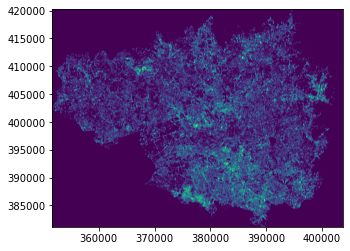

<AxesSubplot:>

In [50]:
# Tree no Trees output layer at 100m
tree_src_100_fft = rasterio.open("thesis_project/output/tree_output_100_fft.tif")
show(tree_src_100_fft, 1)

In [56]:
# output layer metadata
tree_src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

### 3.3.2. Tree no Trees output layer at 300m

In [57]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/tree_output_300_fft.tif', 'w', driver='GTiff',
                            height = tree_output_300_fft.shape[0], width = tree_output_300_fft.shape[1],
                            count=1, dtype=str(tree_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_300_fft, 1)
new_dataset.close()

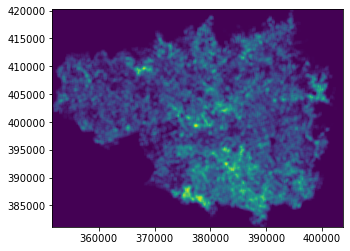

<AxesSubplot:>

In [58]:
# Tree no Trees output layer at 300m
tree_src_300_fft = rasterio.open("thesis_project/output/tree_output_300_fft.tif")
show(tree_src_300_fft, 1)

### 3.3.3. Tree no Trees output layer at 500m

In [59]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/tree_output_500_fft.tif', 'w', driver='GTiff',
                            height = tree_output_500_fft.shape[0], width = tree_output_500_fft.shape[1],
                            count=1, dtype=str(tree_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_500_fft, 1)
new_dataset.close()

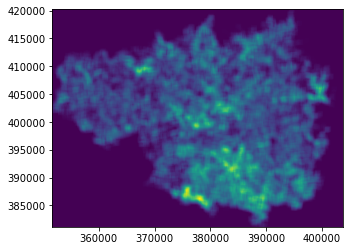

<AxesSubplot:>

In [60]:
# Tree no Trees output layer at 500m
tree_src_500_fft = rasterio.open("thesis_project/output/tree_output_500_fft.tif")
show(tree_src_500_fft, 1)

## 3.4. Extract raster values at point locations and store them into a Geodataframe

### 3.4.1. Tree No Trees values at 100m

In [69]:
# open the raster and store metadata
tree_src_100 = rasterio.open("thesis_project/output/tree_output_100_fft.tif")
tree_src_100.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

In [73]:
# check gdf
gdf_100.head()

,geometry,NDVI_100,Green_100
0,POINT (363393.705 372747.019),0.582414,1.000000
1,POINT (401914.593 424290.216),0.512916,1.000000
2,POINT (355111.797 390514.816),0.494056,1.000000
3,POINT (386970.388 414807.312),0.610928,0.929804
4,POINT (369133.060 373174.495),0.424878,1.000000


In [72]:
# create polygon with tree raster bounds
polygon = Polygon([(351667.1259, 381167.084), (351667.1259, 420207.084), (403905.1259, 420207.084), (403905.1259, 381167.084)])


In [110]:
# keep list of points within tree raster bounds

tree_100_points = []
for p in gdf_100.geometry:
    if polygon.contains(p):
        tree_100_points.append(p)
        
len(tree_100_points) #4954 points within tree raster extent
#tree_100_points

In [97]:
tree_df_100 = pd.DataFrame(tree_100_points, columns=['geometry'])
tree_gdf_100 = gpd.GeoDataFrame(tree_df_100, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_100.head()


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (355111.797 390514.816)
1,POINT (386970.388 414807.312)
2,POINT (362942.655 390812.373)
3,POINT (382846.925 385592.256)
4,POINT (396743.889 396351.002)


In [98]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_100['point_coordinates'] = point_coords
tree_gdf_100.head()

,geometry,point_coordinates
0,POINT (355111.797 390514.816),"(355111.7965112411, 390514.81640177505)"
1,POINT (386970.388 414807.312),"(386970.38799715595, 414807.3118267293)"
2,POINT (362942.655 390812.373),"(362942.6551198272, 390812.3732773438)"
3,POINT (382846.925 385592.256),"(382846.9247625236, 385592.2557761688)"
4,POINT (396743.889 396351.002),"(396743.88903216633, 396351.00236363465)"


In [99]:
# sample the raster at every point location and store values in Geodataframe
tree_gdf_100['Tree_100'] = [x[0] for x in tree_src_100.sample(tree_gdf_100.point_coordinates)]
tree_gdf_100.head()

,geometry,point_coordinates,Tree_100
0,POINT (355111.797 390514.816),"(355111.7965112411, 390514.81640177505)",-8.554407e-10
1,POINT (386970.388 414807.312),"(386970.38799715595, 414807.3118267293)",6.166063e-02
2,POINT (362942.655 390812.373),"(362942.6551198272, 390812.3732773438)",3.201875e-09
3,POINT (382846.925 385592.256),"(382846.9247625236, 385592.2557761688)",1.107735e-01
4,POINT (396743.889 396351.002),"(396743.88903216633, 396351.00236363465)",1.058720e-01


In [100]:
# drop point_coordinates
tree_gdf_100 = tree_gdf_100[['geometry', 'Tree_100']]
tree_gdf_100.head()

,geometry,Tree_100
0,POINT (355111.797 390514.816),-8.554407e-10
1,POINT (386970.388 414807.312),6.166063e-02
2,POINT (362942.655 390812.373),3.201875e-09
3,POINT (382846.925 385592.256),1.107735e-01
4,POINT (396743.889 396351.002),1.058720e-01


In [101]:
# check gdf with other greenspace metrics
gdf_100.head()

,geometry,NDVI_100,Green_100
0,POINT (363393.705 372747.019),0.582414,1.000000
1,POINT (401914.593 424290.216),0.512916,1.000000
2,POINT (355111.797 390514.816),0.494056,1.000000
3,POINT (386970.388 414807.312),0.610928,0.929804
4,POINT (369133.060 373174.495),0.424878,1.000000


In [108]:
# merge gdf with tree gdf on geometry using left operation
gdf_100_complete = pd.merge(gdf_100, tree_gdf_100, on='geometry', how='left')
gdf_100_complete.head()


,geometry,NDVI_100,Green_100,Tree_100
0,POINT (363393.705 372747.019),0.582414,1.000000,NaN
1,POINT (401914.593 424290.216),0.512916,1.000000,NaN
2,POINT (355111.797 390514.816),0.494056,1.000000,-8.554407e-10
3,POINT (386970.388 414807.312),0.610928,0.929804,6.166063e-02
4,POINT (369133.060 373174.495),0.424878,1.000000,NaN


In [107]:
# check if nulls
gdf_100_complete.isnull().values.any()

True

In [109]:
# take rows where 'Tree_100' is not NaN
gdf_100 = gdf_100_complete[gdf_100_complete['Tree_100'].notna()]
len(gdf_100)

4594

In [111]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/greenspace_metrics_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### How to directly convert raster image to point shapefile

In [ ]:
# convert raster to point shapefile
filename='thesis_project/output/ndvi_output_100'
inDs = gdal.Open('{}.tif'.format(filename))
outDs = gdal.Translate('{}.xyz'.format(filename), inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
outDs = None
try:
    os.remove('{}.csv'.format(filename))
except OSError:
    pass
os.rename('{}.xyz'.format(filename), '{}.csv'.format(filename))
os.system('ogr2ogr -f "ESRI Shapefile" -oo X_POSSIBLE_NAMES=X* -oo Y_POSSIBLE_NAMES=Y* -oo KEEP_GEOM_COLUMNS=NO {0}.shp {0}.csv'.format(filename))

In [ ]:
len(gdf_ndvi_100)

In [ ]:
# randomly sample 10000 point locations
gdf_ndvi_100 = gdf_ndvi_100.sample(n = 10000)
gdf_ndvi_100 = gdf_ndvi_100.reset_index(drop=True)
gdf_ndvi_100.head()

In [ ]:
# plot gpd
#gdf_ndvi_100.plot()
type(gdf_ndvi_100)

In [ ]:
# save gpd into shapefile
gdf_ndvi_100.to_file(driver = 'ESRI Shapefile', filename= "thesis_project/output/gdf_ndvi_100_sample.shp")


### Draft

In [ ]:
# creating shapely polygon from raster boundaries (later input to generate_random function)
polygon_geom = Polygon([[341660.6724,490904.6389],
                        [341660.6724,431034.6389],
                        [416090.672,431034.6389],
                        [416090.672,490904.639],
                        [341660.6724, 490904.6389]])
type(polygon_geom)

In [ ]:
# function to generate random point coordinates within raster bounds
def generate_random(number, polygon):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

In [ ]:
# Step 1: Get input %Greenness
# data dir
#data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file:
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

In [ ]:
# All Metadata for the whole raster dataset
green_input_raster.meta

In [ ]:
# create NDVI layers at three different scales (100m, 300m, and 500m)
scales = [21, 61, 101]
#scales = [21]

#ndvi_outputs = []
greenspace_dfs = []

for scale in scales:
    
    kernel = np.ones((scale, scale)) # build kernel 
    ndvi_output = (convolve(ndvi_input_arr, kernel) / np.sum(kernel)).ravel() # convert to 1d array
    greenspace_df = pd.DataFrame(ndvi_output, columns=['NDVI']) # create df
    greenspace_dfs.append(greenspace_df) # append to df list

#    ndvi_outputs.append(ndvi_output)
    
#print(len(ndvi_outputs))
print(len(greenspace_dfs))

In [ ]:
# data frame NDVI at 100m
greenspace_df_100 = greenspace_dfs[0]
greenspace_df_100.head()

In [ ]:
# data frame NDVI at 300m
greenspace_df_300 = greenspace_dfs[1]
greenspace_df_300.head()

In [ ]:
# data frame NDVI at 500m
greenspace_df_500 = greenspace_dfs[2]
greenspace_df_500.head()

In [ ]:
ndvi_output_100.shape

In [ ]:
# check sum of kernel (denominator of average operation)
np.sum(scale_100)

In [ ]:
# output map of averaged neighbour
#output_map_100
ndvi_output_100.shape

In [ ]:
ndvi_output_100_1d = ndvi_output_100.ravel()
ndvi_output_100_1d.shape

In [ ]:
# randomly sample 1000 points from 2d array
np.random.seed(1234) #set seed
ndvi_points_100 = np.random.choice(ndvi_output_100.ravel(), 1000 ,replace=False)
ndvi_points_100

5. Store NDVI values for 1000 points into a df

In [ ]:
# creating a df from array
greenspace_metrics_100 = pd.DataFrame(ndvi_points_100, columns=['NDVI'])
#greenspace_metrics_100.head()
greenspace_metrics_100

Here, repeat again the same process but with %greenness

6. Read %Greenness input file

In [ ]:
# reading raster file using gdal
green_input_map = gdal.Open("thesis_project/data/GreenNoGreenRes.tif")

7. Applying focal statistics to %greenness input map at 100m scale

In [ ]:
# convert input map to array
green_input_arr = np.array(green_input_map.GetRasterBand(1).ReadAsArray())
#green_input_arr
green_input_arr.shape

In [ ]:
# fix kernel shape to 100m scale (21x21)
scale_100 = np.ones((21, 21))
#scale_100
scale_100.shape

In [ ]:
# convolve greenness input map with kernel 100m (equivalent to percentage operation)
green_output_100 = convolve(green_input_arr, scale_100) / np.sum(scale_100) # mode=reflect to extend input beyond its boundaries


8. Output layer averaged at 100m scale

In [ ]:
# greenness output map after performing focal statistics
green_output_100
#green_output_100.shape

10. Store %greenness values for 1000 points into a df

In [ ]:
# adding values to data frame
greenspace_metrics_100['%Greenness'] = green_points_100
#greenspace_metrics_100.head()
greenspace_metrics_100

9. Sample 1000 points and extract %greenness values

In [ ]:
# randomly sample 1000 points
np.random.seed(2345) #set seed
green_points_100 = np.random.choice(green_output_100.ravel(), 1000 ,replace=False)
green_points_100